# Analysis of Neuron Selectivity for DRD87 in EPM, NO, OFT, & POPP

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
from analysis import sig_proc
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


### Import the csv of raw neuron signal data (collected during EPM experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [4]:
DRD87_EPM_DATA = pd.read_csv(raw_files[7], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_EPM_DATA, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

DRD87_EPM_behavior_df = pd.read_csv(raw_files[8], header=None)
drd87_epm_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_EPM_behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



### We compute the actual $\hat{D}$ values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe

In [5]:
epm_real_diff_vals = drd87_epm_fe.set_real_diff_df(drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69,neuron70
D,5.72857,-3.00185,-1.36973,12.1606,-0.555661,-3.64355,8.0656,-3.7702,-0.683886,-3.68069,...,3.74837,-0.92522,0.176564,0.569157,-1.74818,0.711728,1.67555,1.55181,1.89085,4.47428


### Now, we construct the permutation distributions of the $\hat{D}$ values, for each neuron column vector, from its values in a large number of resamples.
### Immediately after we construct our permutation distributions, we plot the distribution of each neuron.

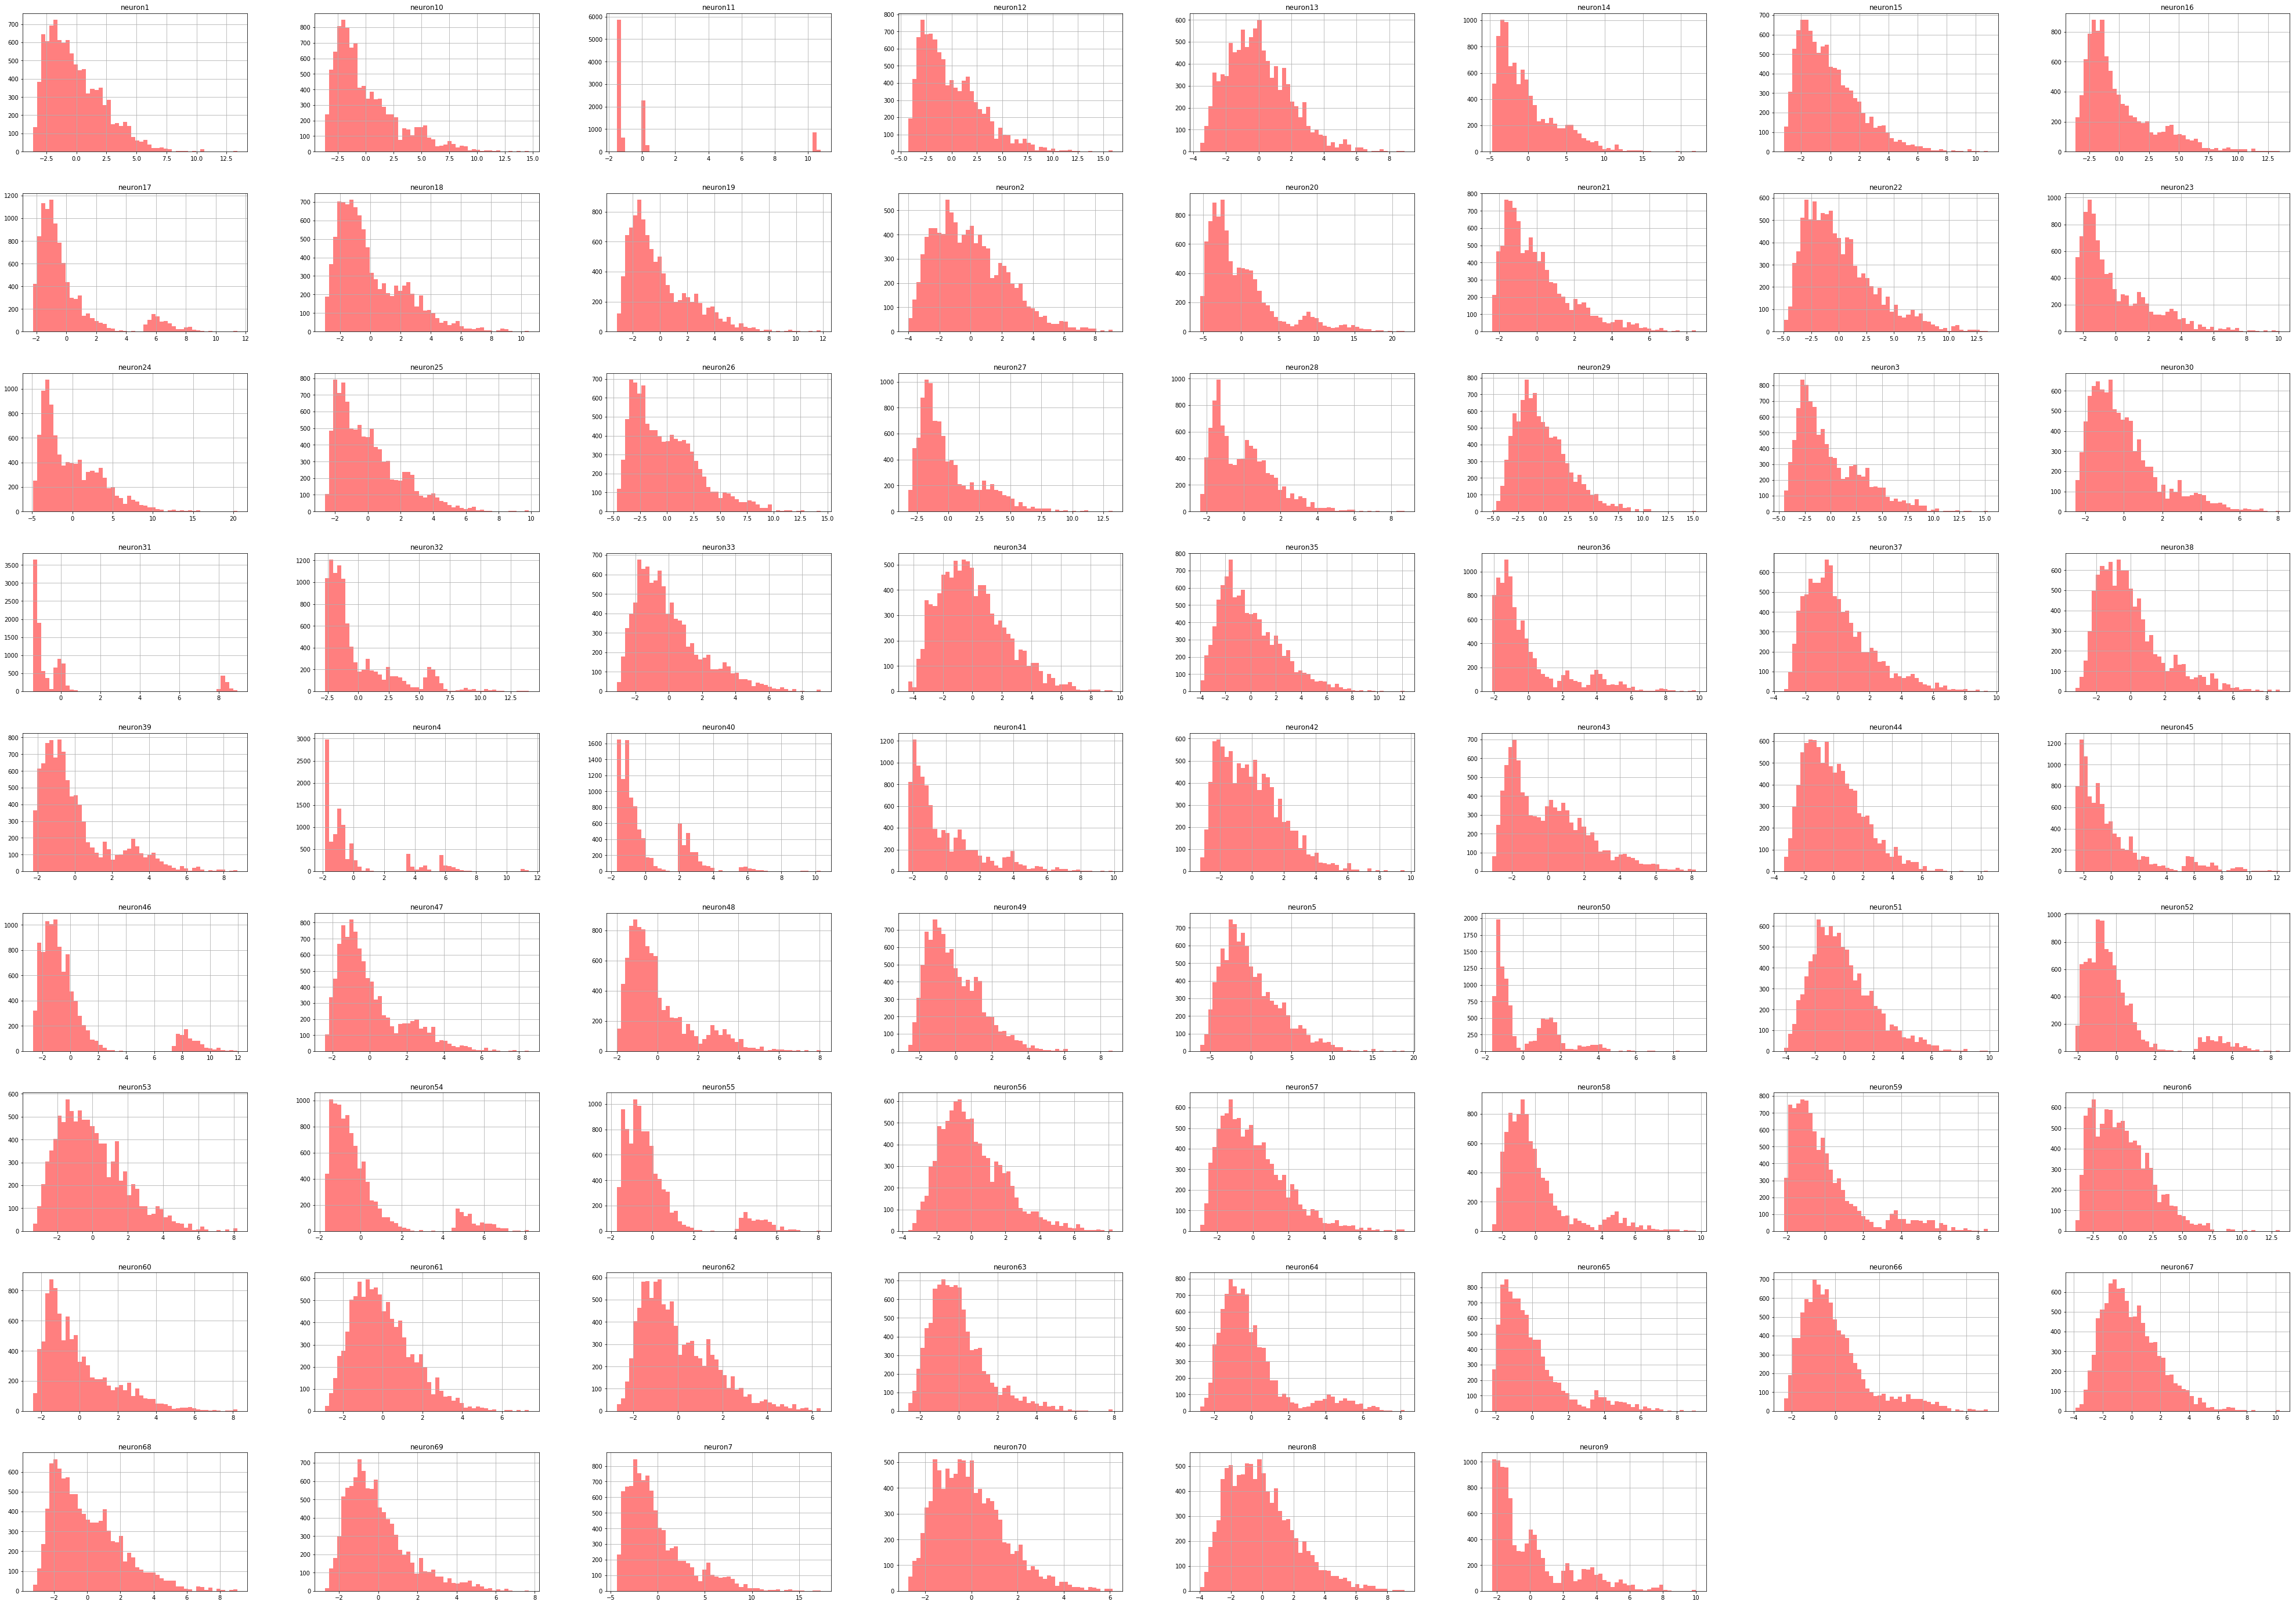

In [6]:
epm_resampled_df = Resampler.shuffle(10000, drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_resampled_df.hist(alpha=0.5, color="red", bins=50, figsize=(70, 50));

In [7]:
def deep_classify(classified_neurons, real_diff_vals, *behaviors):
    deeper_classification = classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[0]
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[1]
                
    return deeper_classification

### Now, we actually conduct the **permuation test**, where we classify neurons as either *selective* or *not-selective*

In [8]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_epm_fe.auc_df, epm_resampled_df, epm_real_diff_vals, p_value=0.1, threshold=5)
epm_selective_neurons = deep_classify(drd87_classified_neurons, epm_real_diff_vals, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_selective_neurons

{'neuron11': 'unclassified',
 'neuron1': 'OpenArms_centerpoint',
 'neuron2': 'not-selective',
 'neuron3': 'not-selective',
 'neuron4': 'OpenArms_centerpoint',
 'neuron5': 'not-selective',
 'neuron6': 'ClosedArms_centerpoint',
 'neuron7': 'OpenArms_centerpoint',
 'neuron8': 'ClosedArms_centerpoint',
 'neuron9': 'not-selective',
 'neuron10': 'not-selective',
 'neuron12': 'not-selective',
 'neuron13': 'not-selective',
 'neuron14': 'not-selective',
 'neuron15': 'not-selective',
 'neuron16': 'not-selective',
 'neuron17': 'OpenArms_centerpoint',
 'neuron18': 'not-selective',
 'neuron19': 'OpenArms_centerpoint',
 'neuron20': 'not-selective',
 'neuron21': 'OpenArms_centerpoint',
 'neuron22': 'not-selective',
 'neuron23': 'OpenArms_centerpoint',
 'neuron24': 'not-selective',
 'neuron25': 'not-selective',
 'neuron26': 'not-selective',
 'neuron27': 'not-selective',
 'neuron28': 'not-selective',
 'neuron29': 'not-selective',
 'neuron30': 'OpenArms_centerpoint',
 'neuron31': 'OpenArms_centerpoint',

In [9]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == "OpenArms_centerpoint"])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "ClosedArms_centerpoint"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "not-selective"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "unclassified"]))
    
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

### After classifying the neurons as either selective, not-selective, or unclassified, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for `OpenArms_centerpoint`. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for `ClosedArms_centerpoint`.

In [10]:
plot_pie_chart(epm_selective_neurons, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## Import the csv of raw neuron signal data (collected during POPP experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [11]:
DRD87_POPP_DATA = pd.read_csv(raw_files[3], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_POPP_DATA, 2, 0.5, 0.2, 10)

DRD87_POPP_behavior_df = pd.read_csv(raw_files[1])
DRD87_POPP_behavior_df.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
DRD87_POPP_behavior_df.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Odor_centerpoint", "Neutral_centerpoint", "Odor_Cup_centerpoint", "Neutral_Cup_centerpoint"]

drd87_popp_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_POPP_behavior_df, row_multiple=2)

In [18]:
auc_dataframe

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron66,neuron67,neuron68,neuron69,neuron70,neuron71,neuron72,neuron73,neuron74,neuron75
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [12]:
popp_real_diff_vals = drd87_popp_fe.set_real_diff_df(drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron66,neuron67,neuron68,neuron69,neuron70,neuron71,neuron72,neuron73,neuron74,neuron75
D,1.92008,4.25264,-3.09435,0.676467,7.49938,-2.32122,4.86393,-2.69076,3.83389,5.27693,...,1.56782,2.88715,2.84779,-0.912353,0.786862,-0.342486,1.66577,4.07939,2.27167,0.907633


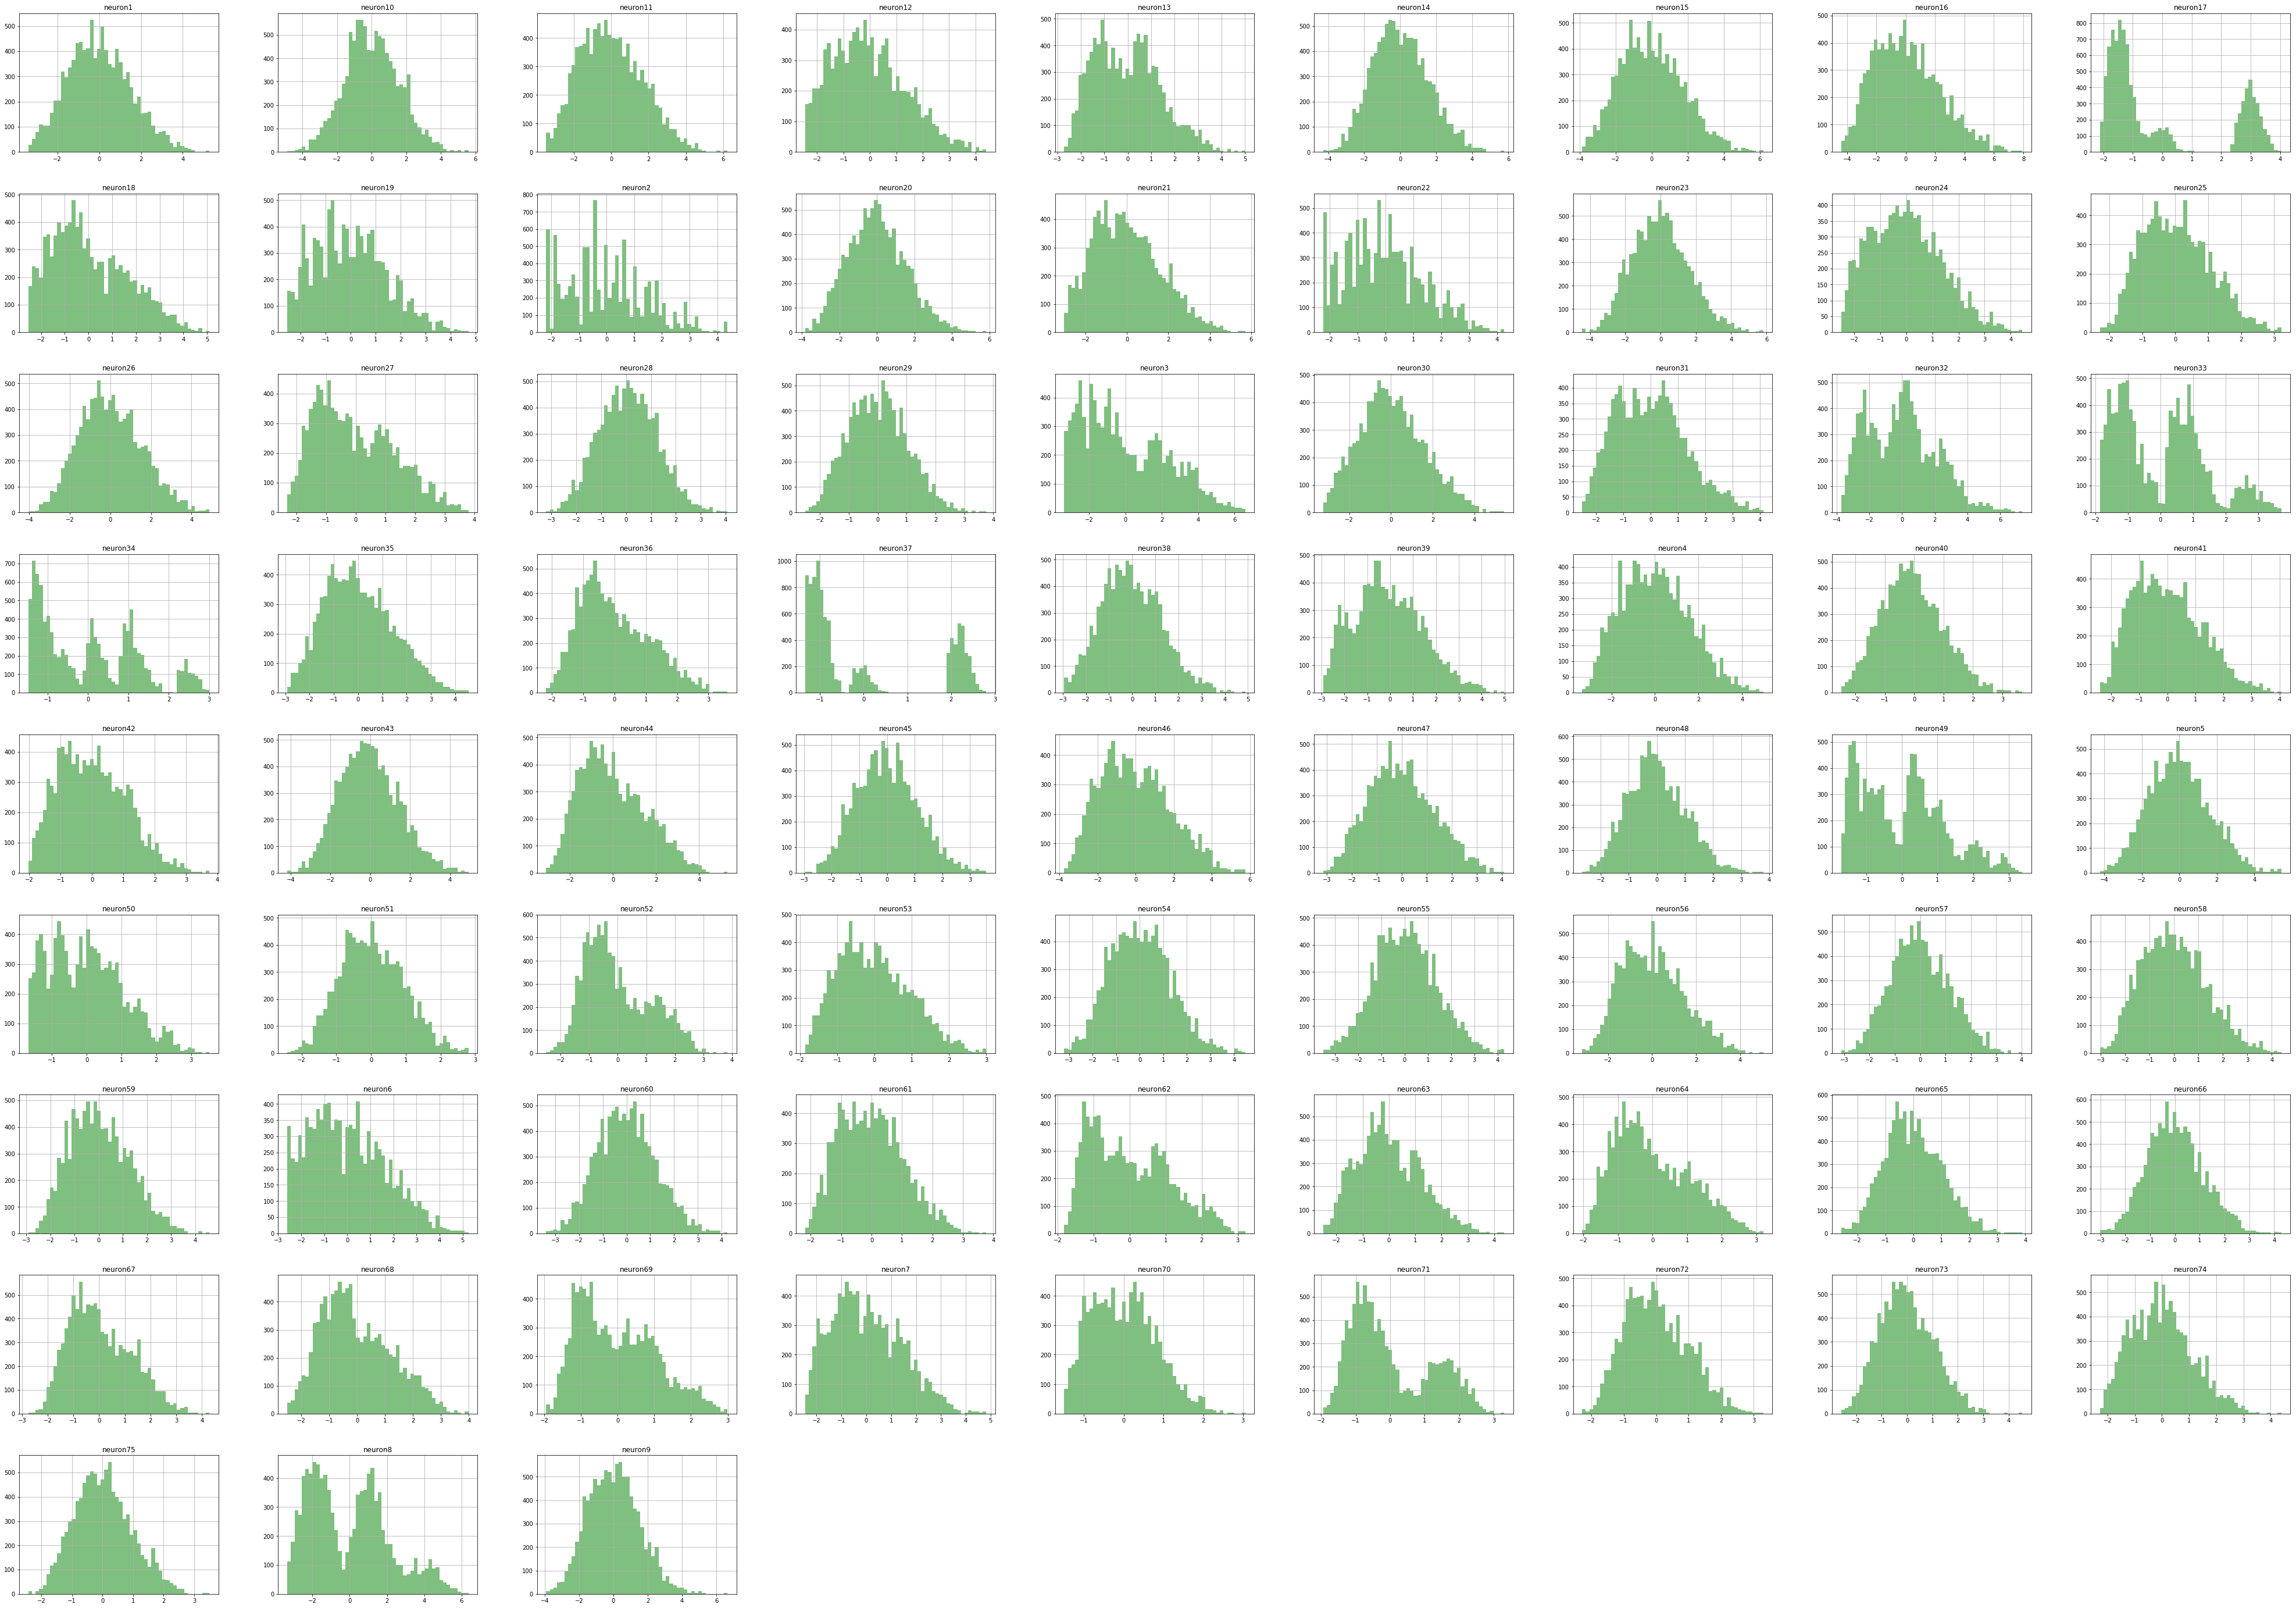

In [13]:
popp_resampled_df = Resampler.shuffle(10000, drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_resampled_df.hist(alpha=0.5, color='green', bins=50, figsize=(70, 50));

In [14]:
def deep_classify(drd87_classified_neurons, real_diff_vals, *behaviors):
    deeper_classification = drd87_classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[0]
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[1]
                
    return deeper_classification

In [15]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_popp_fe.auc_df, popp_resampled_df, popp_real_diff_vals, p_value=0.1, threshold=5)
popp_selective_neurons = deep_classify(drd87_classified_neurons, popp_real_diff_vals, "Odor_centerpoint", "Neutral_centerpoint")
popp_selective_neurons

{'neuron1': 'not-selective',
 'neuron2': 'Odor_centerpoint',
 'neuron3': 'not-selective',
 'neuron4': 'not-selective',
 'neuron5': 'Odor_centerpoint',
 'neuron6': 'not-selective',
 'neuron7': 'Odor_centerpoint',
 'neuron8': 'not-selective',
 'neuron9': 'Odor_centerpoint',
 'neuron10': 'Odor_centerpoint',
 'neuron11': 'Odor_centerpoint',
 'neuron12': 'not-selective',
 'neuron13': 'not-selective',
 'neuron14': 'Neutral_centerpoint',
 'neuron15': 'not-selective',
 'neuron16': 'not-selective',
 'neuron17': 'not-selective',
 'neuron18': 'not-selective',
 'neuron19': 'Odor_centerpoint',
 'neuron20': 'not-selective',
 'neuron21': 'Odor_centerpoint',
 'neuron22': 'not-selective',
 'neuron23': 'Odor_centerpoint',
 'neuron24': 'Neutral_centerpoint',
 'neuron25': 'not-selective',
 'neuron26': 'Odor_centerpoint',
 'neuron27': 'Odor_centerpoint',
 'neuron28': 'Odor_centerpoint',
 'neuron29': 'Odor_centerpoint',
 'neuron30': 'Odor_centerpoint',
 'neuron31': 'Odor_centerpoint',
 'neuron32': 'Neutral_

### We read in the neuron dictionary into a pandas DataFrame, where each column is the identity of the neuron during a particular experiment. 

In [16]:
neuron_dictionary = pd.read_csv("~/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv", header=None)
neuron_dictionary.columns = ["EPM", "NO", "OFT", "POPP"]

### Now, we create a dictionary that will translate the name of the neuron imaged during POPP to the same neuron's name during EPM.

In [19]:
popp_to_epm_dict = dict()

for row in neuron_dictionary.itertuples():
    epm_neuron = getattr(row, "EPM")
    popp_neuron = getattr(row, "POPP")
    
    if popp_neuron == 0:
        # print("Neuron {} was not active during POPP".format(epm_neuron))
        continue
    
    popp_to_epm_dict["neuron"+str(popp_neuron)] = "neuron"+str(epm_neuron)
    
popp_to_epm_dict

{'neuron52': 'neuron1',
 'neuron23': 'neuron2',
 'neuron20': 'neuron3',
 'neuron2': 'neuron4',
 'neuron53': 'neuron8',
 'neuron18': 'neuron10',
 'neuron35': 'neuron11',
 'neuron41': 'neuron15',
 'neuron37': 'neuron17',
 'neuron6': 'neuron18',
 'neuron21': 'neuron19',
 'neuron33': 'neuron20',
 'neuron16': 'neuron21',
 'neuron4': 'neuron23',
 'neuron67': 'neuron24',
 'neuron7': 'neuron25',
 'neuron30': 'neuron27',
 'neuron24': 'neuron28',
 'neuron55': 'neuron30',
 'neuron36': 'neuron31',
 'neuron49': 'neuron33',
 'neuron3': 'neuron36',
 'neuron63': 'neuron37',
 'neuron74': 'neuron38',
 'neuron19': 'neuron39',
 'neuron38': 'neuron41',
 'neuron15': 'neuron42',
 'neuron65': 'neuron43',
 'neuron56': 'neuron44',
 'neuron34': 'neuron48',
 'neuron31': 'neuron50',
 'neuron57': 'neuron51',
 'neuron12': 'neuron52',
 'neuron9': 'neuron53',
 'neuron70': 'neuron54',
 'neuron71': 'neuron55',
 'neuron46': 'neuron57',
 'neuron44': 'neuron58',
 'neuron8': 'neuron59',
 'neuron58': 'neuron61',
 'neuron14':

In [20]:
epm_to_popp_dict = dict()

for row in neuron_dictionary.itertuples():
    epm_neuron = getattr(row, "EPM")
    popp_neuron = getattr(row, "POPP")
    
    if epm_neuron == 0:
        # print("Neuron {} was not active during EPM".format(popp_neuron))
        continue
    
    epm_to_popp_dict["neuron"+str(epm_neuron)] = "neuron"+str(popp_neuron)
    
epm_to_popp_dict

{'neuron1': 'neuron52',
 'neuron2': 'neuron23',
 'neuron3': 'neuron20',
 'neuron4': 'neuron2',
 'neuron5': 'neuron0',
 'neuron6': 'neuron0',
 'neuron7': 'neuron0',
 'neuron8': 'neuron53',
 'neuron9': 'neuron0',
 'neuron10': 'neuron18',
 'neuron11': 'neuron35',
 'neuron12': 'neuron0',
 'neuron13': 'neuron0',
 'neuron14': 'neuron0',
 'neuron15': 'neuron41',
 'neuron16': 'neuron0',
 'neuron17': 'neuron37',
 'neuron18': 'neuron6',
 'neuron19': 'neuron21',
 'neuron20': 'neuron33',
 'neuron21': 'neuron16',
 'neuron22': 'neuron0',
 'neuron23': 'neuron4',
 'neuron24': 'neuron67',
 'neuron25': 'neuron7',
 'neuron26': 'neuron0',
 'neuron27': 'neuron30',
 'neuron28': 'neuron24',
 'neuron29': 'neuron0',
 'neuron30': 'neuron55',
 'neuron31': 'neuron36',
 'neuron32': 'neuron0',
 'neuron33': 'neuron49',
 'neuron34': 'neuron0',
 'neuron35': 'neuron0',
 'neuron36': 'neuron3',
 'neuron37': 'neuron63',
 'neuron38': 'neuron74',
 'neuron39': 'neuron19',
 'neuron40': 'neuron0',
 'neuron41': 'neuron38',
 'ne

#### We know that a grand total of $123$ neurons, in DRD87, were imaged over all 4 experiments. 

In [21]:
total_amount_neurons = len(neuron_dictionary.index)
total_amount_neurons

123

### We want to know the proportion of overlap of "OpenArms_centerpoint" selective neurons, and "Odor_centerpoint" selective cells.

In [22]:
odor_open_selective = 0
for neuron in popp_selective_neurons:
    if popp_selective_neurons[neuron] == "Odor_centerpoint":
        
        if popp_to_epm_dict[neuron] != "neuron0":
            if epm_selective_neurons[popp_to_epm_dict[neuron]] == "OpenArms_centerpoint":
                print("{} ({} during EPM) was also selective for OpenArms_centerpoint in EPM".format(neuron, popp_to_epm_dict[neuron]))
                odor_open_selective += 1
                
print("\n{}% of DRD87's neurons were selective for Odor_centerpoint AND OpenArms_centerpoint".format((odor_open_selective / total_amount_neurons) * 100))

neuron2 (neuron4 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron19 (neuron39 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron21 (neuron19 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron34 (neuron48 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron38 (neuron41 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron44 (neuron58 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron55 (neuron30 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron58 (neuron61 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron74 (neuron38 during EPM) was also selective for OpenArms_centerpoint in EPM

7.317073170731707% of DRD87's neurons were selective for Odor_centerpoint AND OpenArms_centerpoint


### How does this compare to the chance level of overlap? For example, if $30\%$ neurons are EPM selective, and $50\%$ are odor selective, We would expect $0.3 \cdot 0.5 = 0.15 = 15\%$ of the neurons that are found in both, EPM and POPP, to be selective for both "OpenArms_centerpoint" and "Odor_centerpoint".

In [23]:
open_selective_count = 0
for neuron in epm_selective_neurons:
    if epm_selective_neurons[neuron] == "OpenArms_centerpoint":
        # print(neuron)
        open_selective_count += 1

print("\n{} of DRD87's neurons were selective for OpenArms_centerpoint".format(open_selective_count))
print("{}% of DRD87's neurons were selective for OpenArms_centerpoint".format((open_selective_count / total_amount_neurons) * 100))


27 of DRD87's neurons were selective for OpenArms_centerpoint
21.951219512195124% of DRD87's neurons were selective for OpenArms_centerpoint


In [24]:
odor_selective_count = 0
for neuron in popp_selective_neurons:
    if popp_selective_neurons[neuron] == "Odor_centerpoint":
        # print(neuron)
        odor_selective_count += 1

print("\n{} of DRD87's neurons were selective for Odor_centerpoint".format(odor_selective_count))
print("{}% of DRD87's neurons were selective for Odor_centerpoint".format((odor_selective_count / total_amount_neurons) * 100))


39 of DRD87's neurons were selective for Odor_centerpoint
31.70731707317073% of DRD87's neurons were selective for Odor_centerpoint


### Does the identity of a cell in EPM correlate with the activity of the cell in POPP? In other words, for open-selective cells, what is the rate in odor vs. non-odor?

In [25]:
import warnings 

def activity_by_neurons(concated_df, neuron_names, *behaviors, **kwargs):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: DataFrame
        
            A concatenated pandas DataFrame of the neuron activity and 
            the corresponding behavior, for a given animal.
        
        neuron_names: list
        
            The names of the neurons whose rates are to be computed.
        
        behaviors: 
            
            The behaviors for which to compute the activity rates. 
        
        frame_rate: int, optional
        
            The framerate to multiply the activity rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    frame_rate = kwargs.get("frame_rate", None)
    if frame_rate is None:
        warnings.warn("You did not specify a frame rate, so a frame rate"
                      + " of 10 will be utilized in the computation", Warning)
        frame_rate = 10
        
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

### Does the identity of a cell in EPM correlate with the activity of the cell in POPP? In other words, for open-selective cells, what is the rate in odor vs non-odor?

In [26]:
drd87_popp_neuron_activity = activity_by_neurons(drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



In [27]:
for neuron in epm_selective_neurons:
    if epm_selective_neurons[neuron] == "OpenArms_centerpoint":
        if epm_to_popp_dict[neuron] != "neuron0":
            print("{}\n".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron]]))

Odor_centerpoint       2.030988
Neutral_centerpoint    1.989715
Name: neuron52, dtype: float64

Odor_centerpoint       4.357570
Neutral_centerpoint    0.104933
Name: neuron2, dtype: float64

Odor_centerpoint       2.402684
Neutral_centerpoint    0.111488
Name: neuron37, dtype: float64

Odor_centerpoint       6.024019
Neutral_centerpoint    0.111901
Name: neuron21, dtype: float64

Odor_centerpoint       0.000000
Neutral_centerpoint    2.336377
Name: neuron16, dtype: float64

Odor_centerpoint       2.646298
Neutral_centerpoint    1.969832
Name: neuron4, dtype: float64

Odor_centerpoint       5.776876
Neutral_centerpoint    1.535169
Name: neuron55, dtype: float64

Odor_centerpoint       0.355821
Neutral_centerpoint    2.013660
Name: neuron36, dtype: float64

Odor_centerpoint       3.203402
Neutral_centerpoint    0.931730
Name: neuron74, dtype: float64

Odor_centerpoint       3.790556
Neutral_centerpoint    0.735689
Name: neuron19, dtype: float64

Odor_centerpoint       4.573762
Neutral_ce

### Does the identity of a cell in EPM correlate with the activity of the cell in POPP? In other words, for not-selective cells, what is the rate in odor vs. non-odor?

In [28]:
for neuron in epm_selective_neurons:
    if epm_selective_neurons[neuron] == "not-selective":
        if epm_to_popp_dict[neuron] != "neuron0":
            print("{}\n".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron]]))

Odor_centerpoint       6.335772
Neutral_centerpoint    2.128720
Name: neuron23, dtype: float64

Odor_centerpoint       3.031659
Neutral_centerpoint    2.918435
Name: neuron20, dtype: float64

Odor_centerpoint       0.830215
Neutral_centerpoint    2.141634
Name: neuron18, dtype: float64

Odor_centerpoint       3.304787
Neutral_centerpoint    0.933760
Name: neuron41, dtype: float64

Odor_centerpoint       0.000000
Neutral_centerpoint    2.321218
Name: neuron6, dtype: float64

Odor_centerpoint       3.708574
Neutral_centerpoint    0.090675
Name: neuron33, dtype: float64

Odor_centerpoint       4.092450
Neutral_centerpoint    1.205297
Name: neuron67, dtype: float64

Odor_centerpoint       4.962163
Neutral_centerpoint    0.098234
Name: neuron7, dtype: float64

Odor_centerpoint       6.180821
Neutral_centerpoint    0.307974
Name: neuron30, dtype: float64

Odor_centerpoint       0.081379
Neutral_centerpoint    2.467996
Name: neuron24, dtype: float64

Odor_centerpoint       3.063672
Neutral_ce

In [29]:
DRD87_NO_DATA = pd.read_csv(raw_files[6], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_NO_DATA, 2, 0.5, 0.2, 10)

DRD87_NO_behavior_df = pd.read_csv(raw_files[5])
DRD87_NO_behavior_df.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
DRD87_NO_behavior_df.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Novel_Object_centerpoint", "Neutral_Zone_centerpoint"]

drd87_no_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_NO_behavior_df)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [30]:
no_real_diff_vals = drd87_popp_fe.set_real_diff_df(drd87_no_fe.neuron_concated_behavior, drd87_no_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron43,neuron44,neuron45,neuron46,neuron47,neuron48,neuron49,neuron50,neuron51,neuron52
D,-0.982822,1.89006,-4.61537,-6.23302,0.826767,2.46959,-2.97508,2.17559,-11.8144,0.669313,...,0.192681,1.96007,0.9887,-1.45949,-3.65233,-1.99966,-5.82677,-6.80028,-3.72449,2.22875


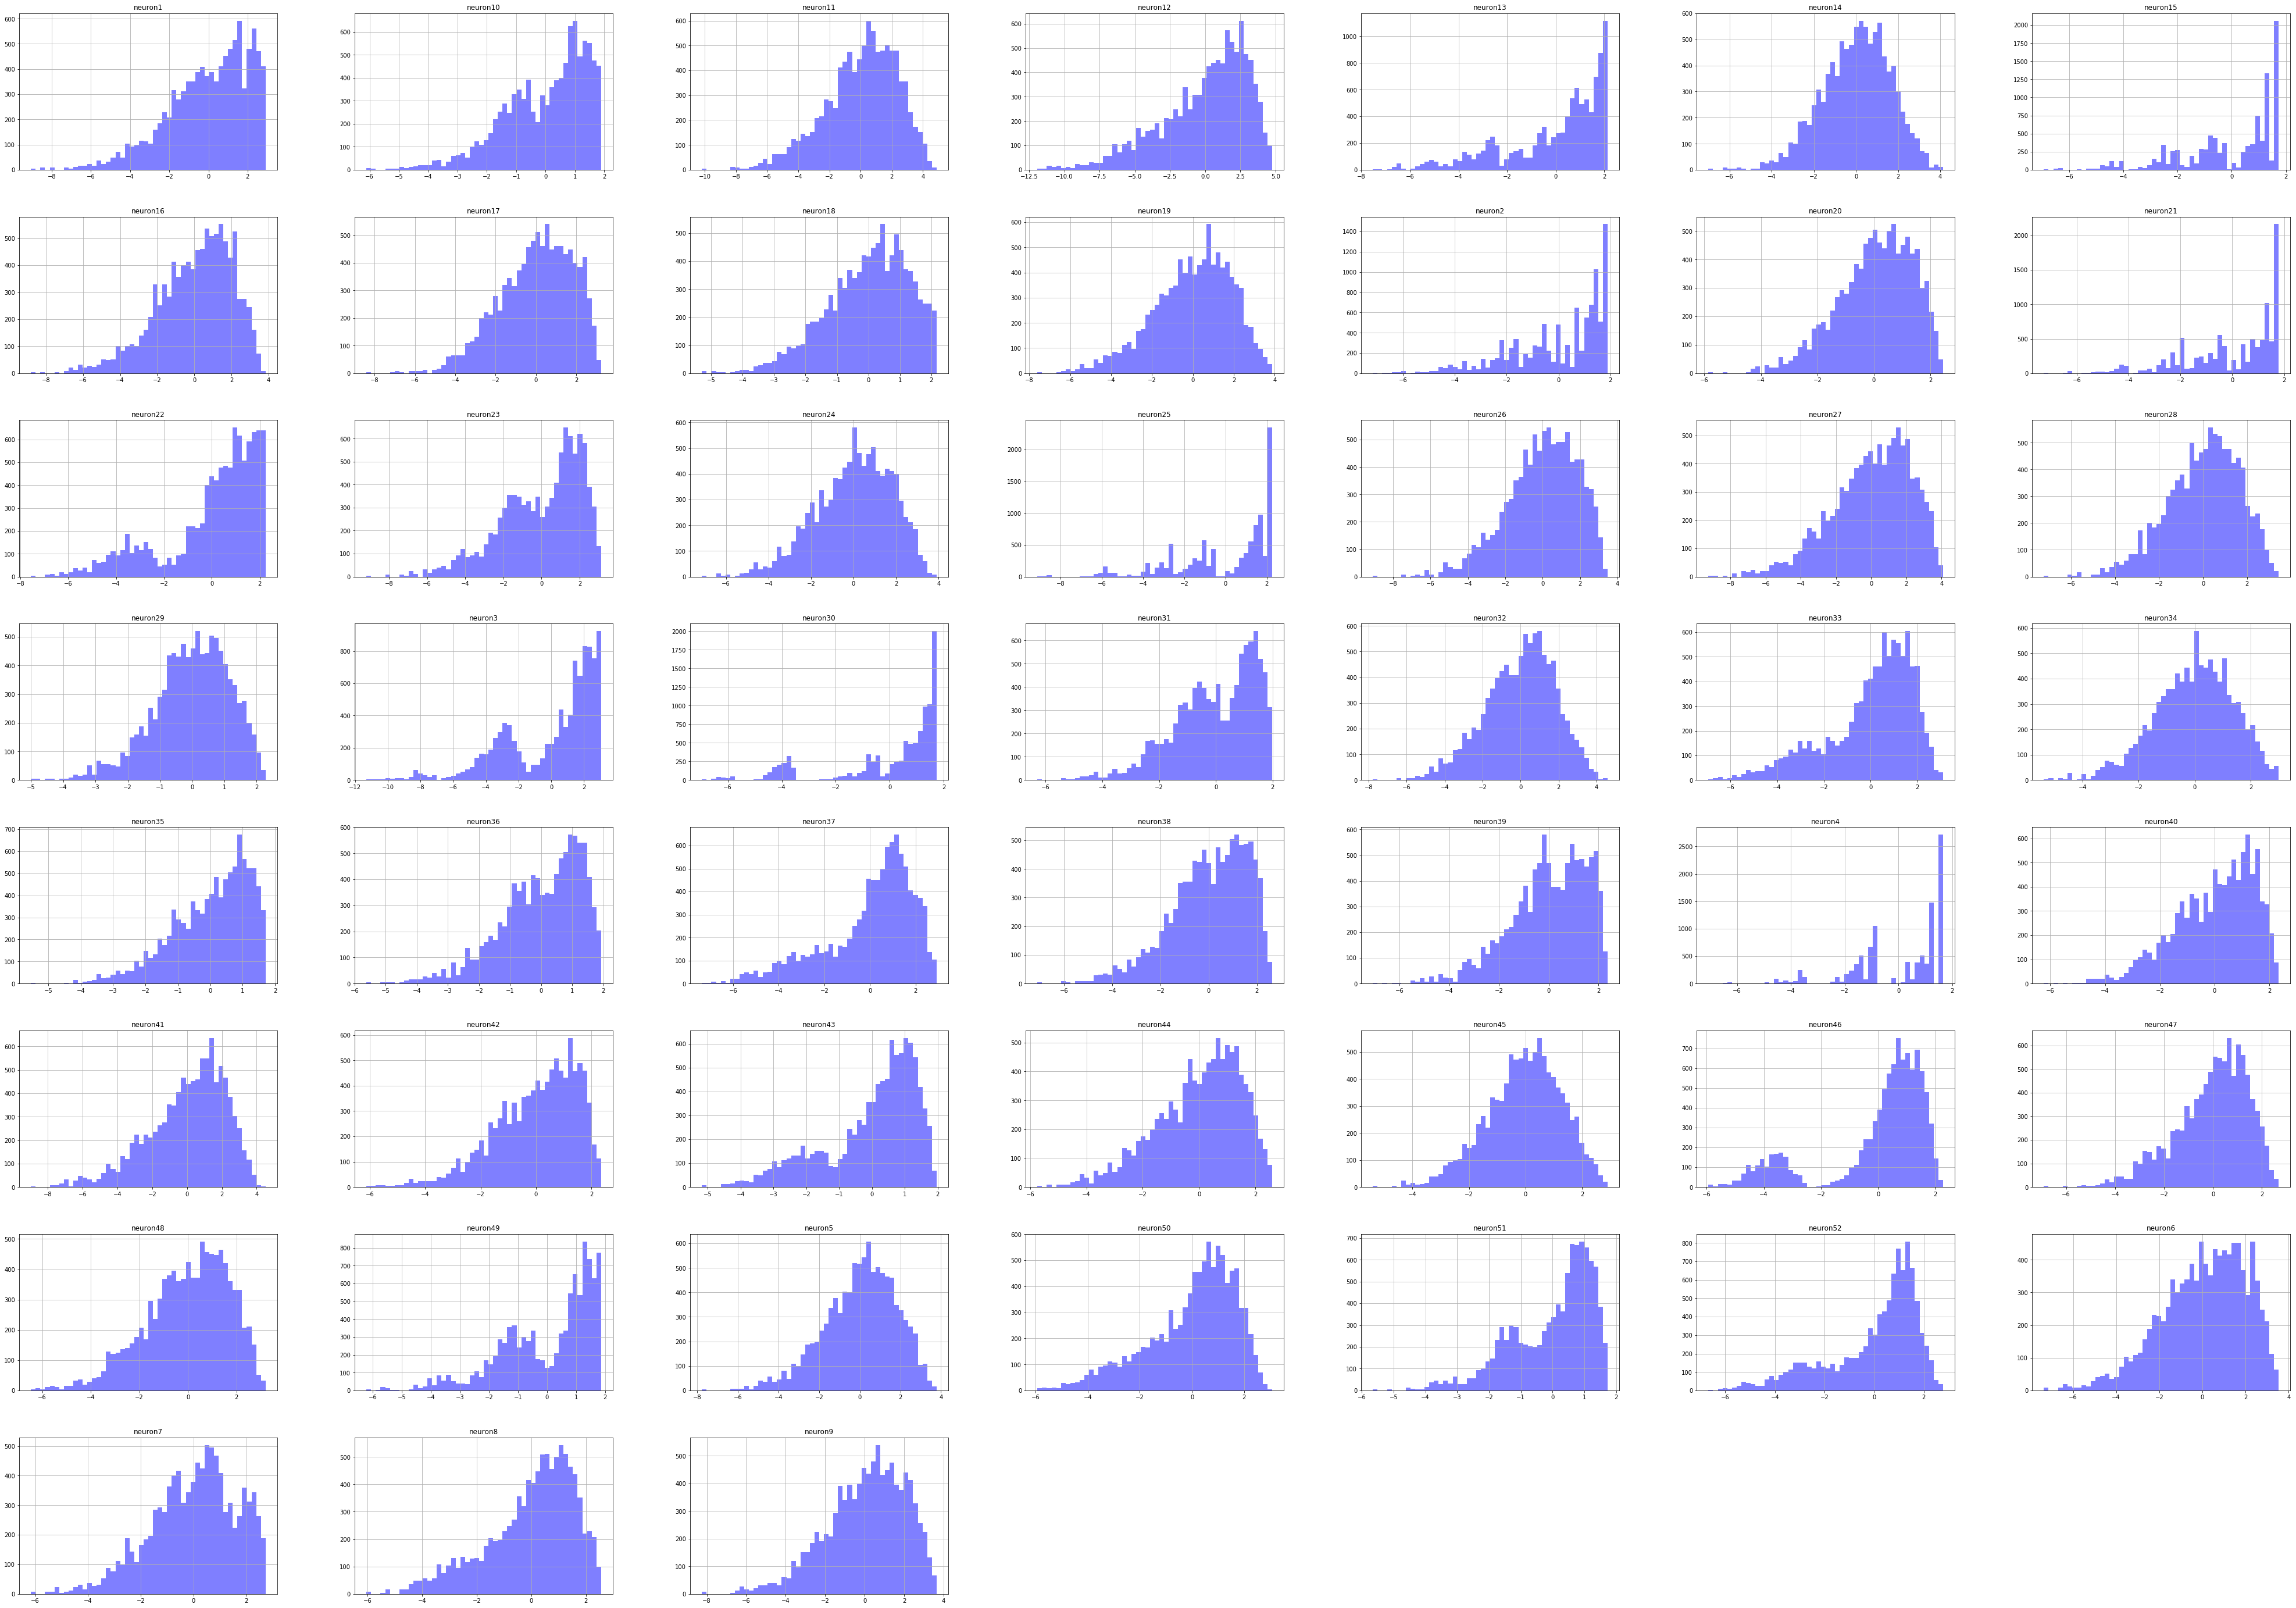

In [31]:
no_resampled_df = Resampler.shuffle(10000, drd87_no_fe.neuron_concated_behavior, drd87_no_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_resampled_df.hist(alpha=0.5, color="blue", bins=50, figsize=(70, 50));

In [32]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_popp_fe.auc_df, popp_resampled_df, popp_real_diff_vals, p_value=0.1, threshold=5)
no_selective_neurons = deep_classify(drd87_classified_neurons, popp_real_diff_vals, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_selective_neurons

{'neuron1': 'not-selective',
 'neuron2': 'Novel_Object_centerpoint',
 'neuron3': 'not-selective',
 'neuron4': 'not-selective',
 'neuron5': 'Novel_Object_centerpoint',
 'neuron6': 'not-selective',
 'neuron7': 'Novel_Object_centerpoint',
 'neuron8': 'not-selective',
 'neuron9': 'Novel_Object_centerpoint',
 'neuron10': 'Novel_Object_centerpoint',
 'neuron11': 'Novel_Object_centerpoint',
 'neuron12': 'not-selective',
 'neuron13': 'not-selective',
 'neuron14': 'Neutral_Zone_centerpoint',
 'neuron15': 'not-selective',
 'neuron16': 'not-selective',
 'neuron17': 'not-selective',
 'neuron18': 'not-selective',
 'neuron19': 'Novel_Object_centerpoint',
 'neuron20': 'not-selective',
 'neuron21': 'Novel_Object_centerpoint',
 'neuron22': 'not-selective',
 'neuron23': 'Novel_Object_centerpoint',
 'neuron24': 'Neutral_Zone_centerpoint',
 'neuron25': 'not-selective',
 'neuron26': 'Novel_Object_centerpoint',
 'neuron27': 'Novel_Object_centerpoint',
 'neuron28': 'Novel_Object_centerpoint',
 'neuron29': 'N